#<B> Residual Network implementation

Making use of the TensorFlow Library.

---
Getting the dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Load Cifar-10 data-set
(train_im, train_lab), (test_im, test_lab) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
#### Normalize the images to pixel values (0, 1)
train_im, test_im = train_im/255.0 , test_im/255.0
#### Check the format of the data 
print ("train_im, train_lab types: ", type(train_im), type(train_lab))
#### check the shape of the data
print ("shape of images and labels array: ", train_im.shape, train_lab.shape) 
print ("shape of images and labels array ; test: ", test_im.shape, test_lab.shape)

train_im, train_lab types:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape of images and labels array:  (50000, 32, 32, 3) (50000, 1)
shape of images and labels array ; test:  (10000, 32, 32, 3) (10000, 1)


In [ ]:
#### Check the distribution of unique elements 
(unique, counts) = np.unique(train_lab, return_counts=True)

frequencies = np.asarray((unique, counts)).T

print (frequencies)
print (len(unique))

[[   0 5000]
 [   1 5000]
 [   2 5000]
 [   3 5000]
 [   4 5000]
 [   5 5000]
 [   6 5000]
 [   7 5000]
 [   8 5000]
 [   9 5000]]
10


In [ ]:
class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'] # from cifar-10 website

---

In [ ]:
### One hot encoding for labels 

train_lab_categorical = tf.keras.utils.to_categorical(
    train_lab, num_classes=10, dtype='uint8')

test_lab_categorical = tf.keras.utils.to_categorical(
    test_lab, num_classes=10, dtype='uint8')

In [ ]:
### Train - Validation split 

from sklearn.model_selection import train_test_split 
train_im, valid_im, train_lab, valid_lab = train_test_split(train_im, train_lab_categorical, test_size=0.20, 
                                                            stratify=train_lab_categorical, 
                                                            random_state=40, shuffle = True)

print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

train data shape after the split:  (40000, 32, 32, 3)
new validation data shape:  (10000, 32, 32, 3)
validation labels shape:  (10000, 10)


In [ ]:
#### Necessary Imports for Neural Net 

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [ ]:
##### Include Little Data Augmentation 
batch_size = 64 # try several values

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
 
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_DataGen.flow(train_im, train_lab, batch_size=batch_size) # train_lab is categorical 
valid_set_conv = valid_datagen.flow(valid_im, valid_lab, batch_size=batch_size) # so as valid_lab 

### Residual Block and Resnet :

### Functions to add a Residual Block 

In [ ]:
def add_residual_block(inp , filters):
  # Identity definiton , The output and the input of the residual function has 
  # the same size , so we can add directly !

  add_to_op = inp       #Used to add the input we got to the feature map of the second convolution layer (Before the activation funciton)
  f1,f2=filters

#First convolution layer    
  inp = Conv2D(f1 , kernel_size=(3,3) ,strides=(1,1) , padding='same' , kernel_regularizer=l2(0.001))(inp)
  inp = BatchNormalization()(inp)
  inp = Activation(activations.relu)(inp)

#Second convolution layer
  inp = Conv2D(f2 , kernel_size=(3,3) ,strides=(1,1) , padding='same' , kernel_regularizer=l2(0.001))(inp)
  inp = BatchNormalization()(inp)

  if(add_to_op.shape[3]!=inp.shape[3]):
    add_to_op = Conv2D(f2,kernel_size=(1,1),padding='same',kernel_regularizer=l2(0.001))(add_to_op)

  inp = Add()([inp,add_to_op])                # Adding the initial input into the residual block
  inp = Activation(activations.relu)(inp)

  return inp

def add_residual_block_with_size_change(inp , s , filters):
  # This will reduce the size of the input and accordingly adjust the addition with a projection matrix

  add_to_op=inp
  f1,f2=filters

  #First convolution layer 
  inp = ZeroPadding2D(padding=(1,1))(inp)
  inp = Conv2D(f1 , kernel_size=(3,3) ,strides=(s,s) , padding='valid' , kernel_regularizer=l2(0.001))(inp)
  inp = BatchNormalization()(inp)
  inp = Activation(activations.relu)(inp)

  #Second convolution layer
  inp = Conv2D(f2 , kernel_size=(3,3) ,strides=(1,1) , padding='same' , kernel_regularizer=l2(0.001))(inp)
  inp = BatchNormalization()(inp)

  # Now the sizes of add_to_op and inp are different , we'll have to make them same before adding 
  add_to_op = Conv2D(f2,kernel_size=(1,1),strides=(s,s),padding='valid',kernel_regularizer=l2(0.001))(add_to_op)
  add_to_op = BatchNormalization()(add_to_op)

  inp = Add()([inp,add_to_op])                # Adding the initial input into the residual block
  inp = Activation(activations.relu)(inp)

  return inp




### Making use of the above functions , we'll build the resnet34 architecture

In [ ]:
def resnet34():
  inp_image = Input(shape=(train_im.shape[1],train_im.shape[2],train_im.shape[3]))


  #First set of residual blocks

  inp = Conv2D(16,kernel_size=(3,3),padding='same',kernel_regularizer=l2(0.001))(inp_image)

  inp = add_residual_block(inp,(16,16))
  inp = add_residual_block(inp,(16,16))

  #Second set of residual blocks
  inp = add_residual_block_with_size_change(inp,2,(32,32))
  inp = add_residual_block(inp,(32,32))

  #Third set of residual blocks
  inp = add_residual_block_with_size_change(inp,2,(64,64))
  inp = add_residual_block(inp,(64,64))

  # #Fourth set of residual blocks
  # inp = add_residual_block_with_size_change(inp,2,(512,512))
  # inp = add_residual_block(inp,(512,512))
  # inp = add_residual_block(inp,(512,512))

  # Average pooling and then , flatten to pass into softmax
  inp = AveragePooling2D((2,2),padding='same')(inp)
  inp = Flatten()(inp)
  inp = Dense(len(class_types),activation='softmax',kernel_initializer='he_normal')(inp)

  model = Model(inputs=inp_image,outputs=inp,name='Resnet34')

  return model


In [ ]:
### Define some Callbacks
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr
  # if epoch < 40:
  #   return 0.01
  # else:
  #   return 0.01 * np.math.exp(0.03 * (40 - epoch))
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  


def earlystop(mode):
  if mode=='acc':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
  elif mode=='loss':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
  return estop    

In [ ]:
resnet34_model = resnet34()

In [ ]:
resnet34_model.summary()

Model: "Resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   2320        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d_1[0][0]                   
___________________________________________________________________________________________

In [ ]:
resnet34_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

In [ ]:
batch_size=batch_size # test with 64, 128, 256

resnet_train = resnet34_model.fit(train_set_conv, 
                                  epochs=160, 
                                  steps_per_epoch=train_im.shape[0]/batch_size, 
                                  validation_steps=valid_im.shape[0]/batch_size, 
                                  validation_data=valid_set_conv, 
                                  callbacks=[lrdecay])

Epoch 1/160
625/625 [==============================] - 22s 36ms/step - loss: 1.2885 - acc: 0.6586 - val_loss: 2.3605 - val_acc: 0.4559
Epoch 2/160
625/625 [==============================] - 22s 35ms/step - loss: 1.1554 - acc: 0.6913 - val_loss: 1.6628 - val_acc: 0.6054
Epoch 3/160
625/625 [==============================] - 22s 35ms/step - loss: 1.0820 - acc: 0.7136 - val_loss: 1.5005 - val_acc: 0.5993
Epoch 4/160
625/625 [==============================] - 22s 35ms/step - loss: 1.0200 - acc: 0.7344 - val_loss: 1.2244 - val_acc: 0.6844
Epoch 5/160
625/625 [==============================] - 22s 35ms/step - loss: 0.9805 - acc: 0.7460 - val_loss: 1.2267 - val_acc: 0.6790
Epoch 6/160
625/625 [==============================] - 22s 35ms/step - loss: 0.9410 - acc: 0.7582 - val_loss: 1.0714 - val_acc: 0.7268
Epoch 7/160
625/625 [==============================] - 22s 35ms/step - loss: 0.9227 - acc: 0.7642 - val_loss: 1.0406 - val_acc: 0.7322
Epoch 8/160
625/625 [==============================] - 

In [ ]:
resnet34_model.save('/content/drive/MyDrive/Colab Notebooks/resnet_model/')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/resnet_model/assets


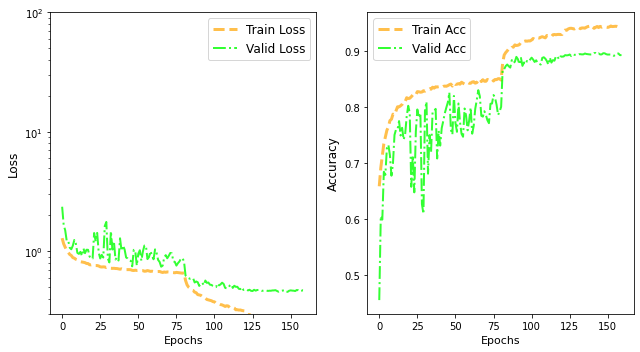

In [ ]:
### Plot train and validation curves
loss = resnet_train.history['loss']
v_loss = resnet_train.history['val_loss']

acc = resnet_train.history['acc']
v_acc = resnet_train.history['val_acc']

epochs = range(len(loss))

fig = plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/resnet/train_acc.png', dpi=250)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import  drive
drive.mount('/content/gdrive')

In [ ]:
#### Plot the Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def conf_matrix(predictions): 
    ''' Plots conf. matrix and classification report '''
    cm=confusion_matrix(test_lab, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr=classification_report(test_lab,
                                np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)
    plt.figure(figsize=(12,12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d")
    fig = sns_hmp.get_figure()
    fig.savefig('/content/drive/MyDrive/Colab Notebooks/resnet/heatmap.png', dpi=250)

Classification Report:

              precision    recall  f1-score   support

    airplane       0.72      0.93      0.81      1000
  automobile       0.93      0.97      0.95      1000
        bird       0.90      0.83      0.86      1000
         cat       0.86      0.72      0.78      1000
        deer       0.90      0.86      0.88      1000
         dog       0.90      0.76      0.83      1000
        frog       0.81      0.97      0.88      1000
       horse       0.96      0.92      0.94      1000
        ship       0.96      0.93      0.94      1000
       truck       0.94      0.93      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



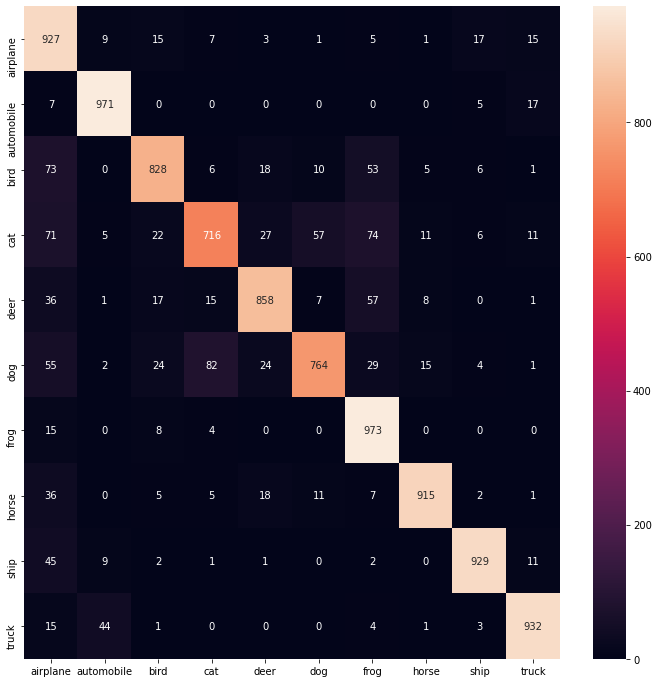

In [ ]:
pred_class_resnet34 = resnet34_model.predict(test_im)

conf_matrix(pred_class_resnet34)

In [ ]:
### Resutls on Test Data; 
## Check the performance on the test data 
test_result = resnet34_model.evaluate(test_im, test_lab_categorical, verbose=0)

print ("ResNet34 loss: ", test_result[0])
print ("ResNet34 accuracy: ", test_result[1])

ResNet50 loss:  0.4908643662929535
ResNet50 accuracy:  0.8892999887466431
